## Spin wave propagation in a stripe with DMI

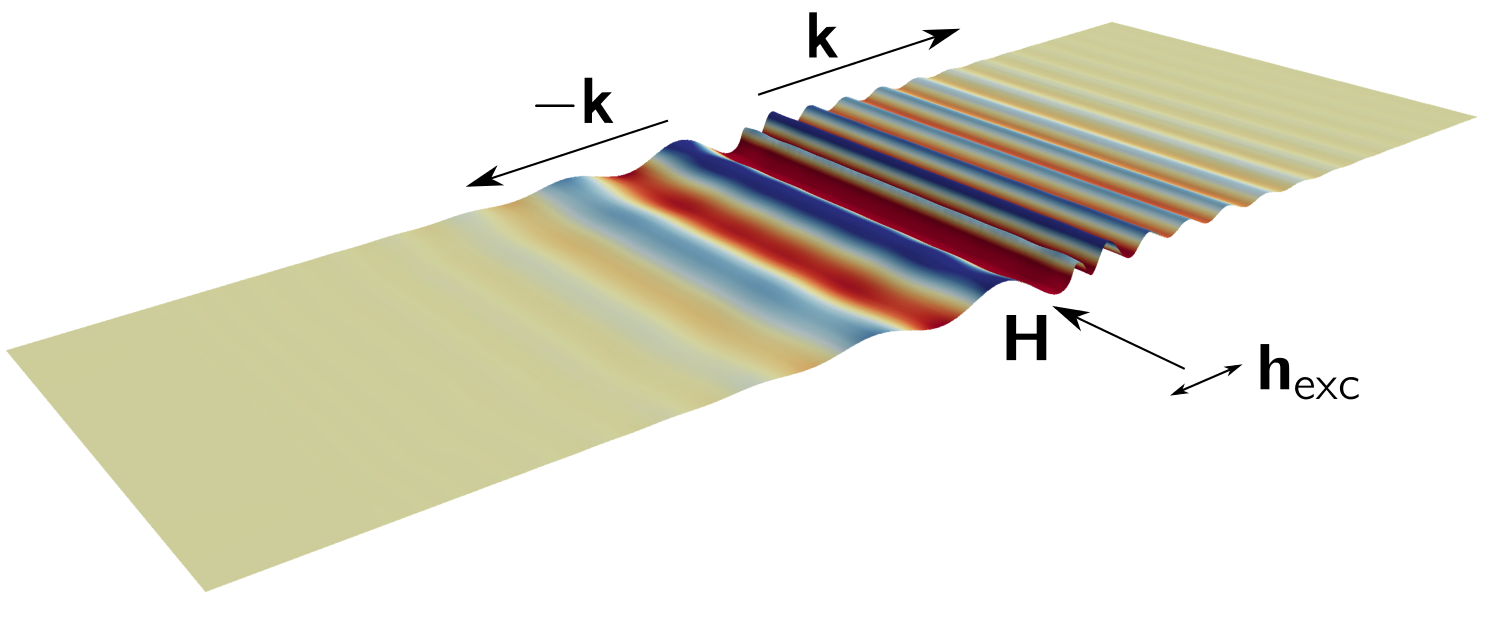

In [1]:
from IPython.display import Image
Image('mayavi/sws/sws.png')

# Imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('lato_style.mplstyle')

import scipy.interpolate
import scipy.optimize

# Theory

Theory from Moon et al. [PHYSICAL REVIEW B **88**, 184404 (2013)] to compute the spin wave spectrum:

$$
\frac{f}{\gamma^{\star}} = pD^{\star}k + \sqrt{ (H + M_{s}/4 + Jk^{2})(H + 3 M_{s}/4 + J k^{2})
                                                 - \frac{e^{-4|k|d}M_{s}^2}{16} (1 + 2e^{2|k|d})
                                                 }
$$

where $\gamma^{\star}=\gamma\mu_{0}(2\pi)^{-1}$ (in Hz / (A/m) ), $p=\pm 1$ is given by the magnetisation direction (+1 in our case) and $D^{\star}=2D(\mu_{0}M_{s})^{-1}$

In [3]:
def Omega_Moon(H0, Ms, A, D, k, d, gamma, p=1):
    mu0 = 4 * np.pi * 1e-7
    J = 2 * A / (mu0 * Ms)
    DM = 2 * D / (mu0 * Ms)
    
    om = np.sqrt((H0 + 0.25 * Ms + J * (k ** 2)) * (H0 + 3 * Ms * 0.25 + J * (k **2))
                 - (1 + 2 * np.exp(2 * abs(k) * d)) * np.exp(-4 * abs(k) * d) * (Ms ** 2) / 16 
                 ) 
    om += p * DM * k
    
    # the mu0 factor shown in the paper is not necessary if we use gamma
    # in Hz / (A / m)
    om = (gamma) * om
    
    return om

# Simulations

We will run the scripts for the simulation of spin waves using both OOMMF and Fidimag:

In [ ]:
!cd ../sims/spin_waves_sims/oommf/dmi && make

In [ ]:
!cd ../sims/spin_waves_sims/fidimag/dmi && make

# Comparison with OOMMF/Fidimag/MuMax3 simulations

Load the data from the OOMMF and Fidimag simulations

In [4]:
base_folder = '../sims/spin_waves_sims/oommf/dmi/'
im_data_OOMMF = np.loadtxt(base_folder + 'spectra_log10.dat')
im_data_f_OOMMF = np.loadtxt(base_folder + 'spectra_log10_freqs.dat')
im_data_k_OOMMF = np.loadtxt(base_folder + 'spectra_log10_ks.dat')

base_folder = '../sims/spin_waves_sims/fidimag/dmi/'
im_data_Fidimag = np.loadtxt(base_folder + 'spectra_log10.dat')
im_data_f_Fidimag = np.loadtxt(base_folder + 'spectra_log10_freqs.dat')
im_data_k_Fidimag = np.loadtxt(base_folder + 'spectra_log10_ks.dat')

base_folder = '../sims/spin_waves_sims/mumax3/dmi/'
im_data_MuMax3 = np.loadtxt(base_folder + 'spectra_log10.dat')
im_data_f_MuMax3 = np.loadtxt(base_folder + 'spectra_log10_freqs.dat')
im_data_k_MuMax3 = np.loadtxt(base_folder + 'spectra_log10_ks.dat')

We will scale the maximum values shown in the spectra:

In [5]:
cbmax_OOMMF = im_data_OOMMF.max() / 1
cbmin_OOMMF = im_data_OOMMF.min() / 9

cbmax_Fidimag = im_data_Fidimag.max() / 1
cbmin_Fidimag = im_data_Fidimag.min() / 9

cbmax_MuMax3 = im_data_MuMax3.max() / 1
cbmin_MuMax3 = im_data_MuMax3.min() / 9

We set the magnetic parameters for the comparison with the theory of Moon et al. Notice that we define $\gamma$ such that the spectrum will be given by the frequency $f=\omega/2\pi$

In [6]:
mu0 = 4 * np.pi * 1e-7
A_si = 13e-12      # J * m**-1
DM_si = 3e-3        # J * m**-2
# Ku_si = 0e6          # J * m**-3
Ms_si = 0.86e6      # A / m
B0_si = 0.4          # T
d = 1e-9             # nm
H0_si = B0_si / mu0  # A /m
#  We will compute f and not omega = 2 PI f
gamma_si = 1e-9 * 2.21e5 / (2 * np.pi)  # GHz / (A / m) - Notice that 2.21e5 = 1.76e11 * mu0

Define the range of wave vector magnitudes and compute the spin wave spectrum

In [7]:
kmax = 0.4 * 1e9
phi_k = 0.5 * np.pi
ks = np.linspace(1e-10, kmax, 500)
ks_n = np.linspace(-kmax, 1e-10, 500)
oms = Omega_Moon(H0_si, Ms_si, A_si, DM_si, ks, d, gamma_si, p=1)
oms_n = Omega_Moon(H0_si, Ms_si, A_si, DM_si, ks_n, d, gamma_si, p=1) 

And finally we plot with respect to the intensity spectrum from the OOMMf simulation

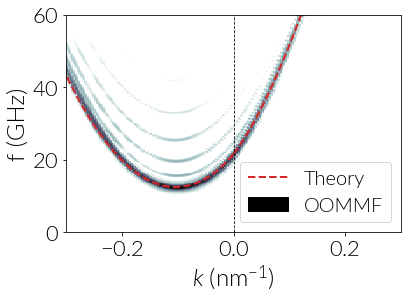

In [8]:
f = plt.figure()
ax= f.add_subplot(111)

ax.imshow(im_data_OOMMF, aspect='auto', vmin=cbmin_OOMMF, vmax=cbmax_OOMMF,
          extent=[im_data_k_OOMMF[0], im_data_k_OOMMF[-1],
                  im_data_f_OOMMF[0], im_data_f_OOMMF[-1]],
          cmap='bone_r')

ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='C3', label='Theory')
ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', color='C3')
plt.axvline(x=0, color='k', ls='--', lw=0.8)

ax.set_xlim(-0.3, 0.3)
ax.set_ylim(0, 60)

ax.set_xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
ax.set_ylabel('f (GHz)')

handles, labels = ax.get_legend_handles_labels()
blacks = matplotlib.patches.Patch(color='k', label='OOMMF')
l = ax.legend(handles=[handles[0], blacks], loc=4)

# plt.savefig('figures/result_spin-waves-oommf.pdf', bbox_inches='tight')

For the Fidimag simulation:

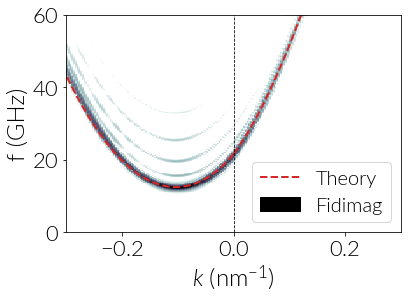

In [9]:
f = plt.figure()
ax= f.add_subplot(111)

ax.imshow(im_data_Fidimag, aspect='auto', vmin=cbmin_Fidimag, vmax=cbmax_Fidimag,
          extent=[im_data_k_Fidimag[0], im_data_k_Fidimag[-1],
                  im_data_f_Fidimag[0], im_data_f_Fidimag[-1]],
          cmap='bone_r')

ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='C3', label='Theory')
ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', color='C3')
plt.axvline(x=0, color='k', ls='--', lw=0.8)

ax.set_xlim(-0.3, 0.3)
ax.set_ylim(0, 60)

ax.set_xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
ax.set_ylabel('f (GHz)')

handles, labels = ax.get_legend_handles_labels()
blacks = matplotlib.patches.Patch(color='k', label='Fidimag')
l = ax.legend(handles=[handles[0], blacks], loc=4)

# plt.savefig('figures/result_spin-waves-fidimag.pdf', bbox_inches='tight')

And the MuMax3 simulation:

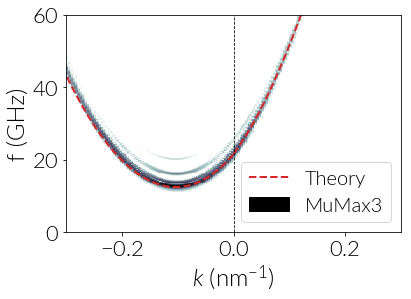

In [10]:
f = plt.figure()
ax= f.add_subplot(111)

ax.imshow(im_data_MuMax3, aspect='auto', vmin=cbmin_MuMax3, vmax=cbmax_MuMax3,
          extent=[im_data_k_MuMax3[0], im_data_k_MuMax3[-1],
                  im_data_f_MuMax3[0], im_data_f_MuMax3[-1]],
          cmap='bone_r')

ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='C3', label='Theory')
ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', color='C3')
plt.axvline(x=0, color='k', ls='--', lw=0.8)

ax.set_xlim(-0.3, 0.3)
ax.set_ylim(0, 60)

ax.set_xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
ax.set_ylabel('f (GHz)')

handles, labels = ax.get_legend_handles_labels()
blacks = matplotlib.patches.Patch(color='k', label='MuMax3')
l = ax.legend(handles=[handles[0], blacks], loc=4)

# plt.savefig('result_spin-waves-mumax.pdf', bbox_inches='tight')

# Comparison with theory

The minimum of the dispersion relation, predicted by the theory is:

In [11]:
k_theory_min = scipy.optimize.fmin(lambda k: Omega_Moon(H0_si, Ms_si, A_si, DM_si, k * 1e9, d, gamma_si, p=1), 
                                   -0.15, disp=False)[0]
print('Theoretical k_min =', k_theory_min, 'nm^-1')
print('Theoretical f_min =', Omega_Moon(H0_si, Ms_si, A_si, DM_si, k_theory_min * 1e9, d, gamma_si, p=1), 'GHz')

Theoretical k_min = -0.10359374999999987 nm^-1
Theoretical f_min = 12.409794887362354 GHz


We can find the minima in the spin wave spectra from the simulations by taking the largest peak for every $k$ value. We restrict the range of frequencies between 0 and 60 GHz 

In [12]:
def compute_peaks(im_data, im_data_f, im_data_k):

    peaks_f = []
    peaks_k = []

    # Filter the frequencies between 0 and 60 GHz
    f_filter = np.logical_and(im_data_f > 0, im_data_f < 60)

    # Invert the data of the spectrum since ImShow already inverts the
    # array order
    data = im_data[-1::-1]
    for i, k in enumerate(im_data_k):

        if k < -0.3 or k > 0.3:
            continue
        else:
            peak_index = np.where(data[:, i][f_filter] == np.max(data[:, i][f_filter]))[0]
            peaks_f.append(im_data_f[f_filter][peak_index][0])
            peaks_k.append(k)

    peaks_k = np.array(peaks_k)
    peaks_f = np.array(peaks_f)
    
    return peaks_k, peaks_f

We start computing the magnitudes for Fidimag

In [13]:
peaks_k_F, peaks_f_F = compute_peaks(im_data_Fidimag, im_data_f_Fidimag, im_data_k_Fidimag)

Since we used a cutoff frequency of 60 GHz in the simulations, values above this threshold are not defined. Below we show the peaks computed with the function we previously defined:

Text(0,0.5,'f (GHz)')

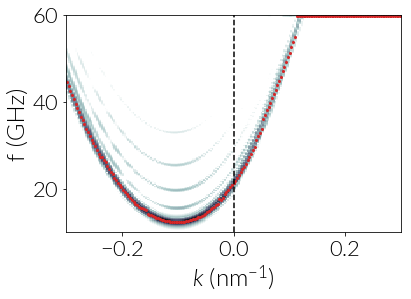

In [14]:
plt.imshow(im_data_Fidimag, aspect='auto', vmin=cbmin_Fidimag, vmax=cbmax_Fidimag,
           extent=[im_data_k_Fidimag[0], im_data_k_Fidimag[-1],
                   im_data_f_Fidimag[0], im_data_f_Fidimag[-1]],
           cmap='bone_r')

plt.plot(peaks_k_F, peaks_f_F, 'oC3', ms=2)
plt.axvline(x=0., ls='--', color='k')

plt.xlim(-0.3, 0.3)
plt.ylim(10, 60)

plt.xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
plt.ylabel('f (GHz)')

From the logarithmic scale, peaks for $k>0$ are not intense enough, thus we will use a 2nd order polynomial fit using values up to approximately $k=0$:

In [15]:
print('Computing values up to k =', peaks_k_F[100], 'nm^-1')
coefs = np.polyfit(peaks_k_F[:100], peaks_f_F[:100], 2)
interp_sim_F = np.poly1d(coefs)

Computing values up to k = 0.015707963267948967 nm^-1


Now we can find the minimum in the spin wave spectrum:

In [16]:
k_sim_min_F = scipy.optimize.fmin(interp_sim_F, -0.15, disp=False)[0]
print('Simulation k_min =', k_sim_min_F)

Simulation k_min = -0.10300781249999988


Here we compare the 2nd order polynomial fit to the data with the peaks, with the theoretical curve. We also show the points where the minima lie: 

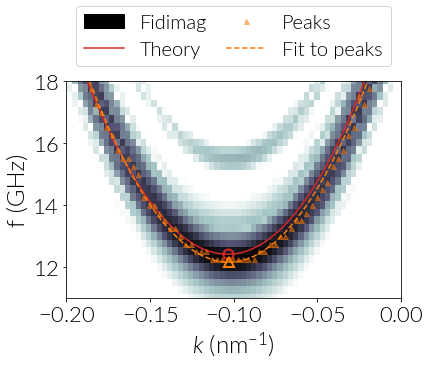

In [17]:
plt.imshow(im_data_Fidimag, aspect='auto', vmin=cbmin_Fidimag, vmax=cbmax_Fidimag,
           extent=[im_data_k_Fidimag[0], im_data_k_Fidimag[-1],
                   im_data_f_Fidimag[0], im_data_f_Fidimag[-1]],
           cmap='bone_r')

# Curve from theory
plt.plot(ks * 1e-9, oms, lw=1.5, ls='-', color='C3', label='Theory')
plt.plot(ks_n * 1e-9, oms_n, lw=1.5, ls='-', color='C3')

# Minimum from theory
plt.plot([k_theory_min], [Omega_Moon(H0_si, Ms_si, A_si, DM_si, k_theory_min * 1e9, d, gamma_si, p=1)], 
         'o', ms=10, markerfacecolor='None', mew=2, color='C3')

# Peaks from simulation
plt.plot(peaks_k_F, peaks_f_F, '^C1', ms=5, alpha=0.5, label='Peaks')

# Curve fit to the peaks from simulation
kk = np.linspace(-0.3, 0.3, 100)
plt.plot(kk, interp_sim_F(kk), '--C1', label='Fit to peaks',)
# Minimum from simulation
plt.plot([k_sim_min_F], [interp_sim_F(k_sim_min_F)], '^C1',
         ms=10, markerfacecolor='None', mew=2)


plt.xlim(-0.2, 0.)
plt.ylim(11, 18)

plt.xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
plt.ylabel('f (GHz)')

handles, labels = plt.gca().get_legend_handles_labels()
blacks = matplotlib.patches.Patch(color='k', label='Fidimag')
l = plt.legend(handles=[blacks, handles[0], handles[1], handles[2]], ncol=2,
               loc='lower left', bbox_to_anchor=(0, 1.02, 1.0, 1), mode='expand')

plt.savefig('result_spin-waves_peaks_sim-theory.pdf',
            bbox_inches='tight')

From the fit to the data we can also compute the DMI constant $D$ and prove that it matches with the one specified in the simulation. From the theory of Moon et al. (or Cortes et al.), the spin wave spectrum asymmetry is defined as (notice that $\gamma$ is in $\text{Hz T}^{-1}$)

$$
\Delta f = f(k) - f(-k) = \frac{2 D \gamma}{\mu_{0} \pi M_{s}} k = \xi \: k
$$

Therefore the asymmetry from our results should be linear, as the theory predicts:

In [18]:
asymm_T = []
for k in np.linspace(0, 0.3, 100):
    asymm_T.append([k, Omega_Moon(H0_si, Ms_si, A_si, DM_si, k * 1e9, d, gamma_si, p=1) - 
                       Omega_Moon(H0_si, Ms_si, A_si, DM_si, -k * 1e9, d, gamma_si, p=1)])
asymm_T = np.array(asymm_T)

asymm_F = []
for k in kk[np.logical_and(kk > 0, kk < 0.3)]:
    asymm_F.append([k, interp_sim_F(k) - interp_sim_F(-k)])
asymm_F = np.array(asymm_F)

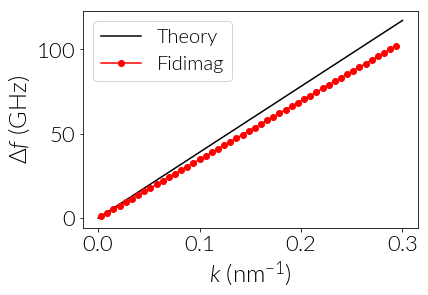

In [19]:
plt.plot(asymm_T[:, 0], asymm_T[:, 1], '-k', label='Theory')
plt.plot(asymm_F[:, 0], asymm_F[:, 1], 'o-r', label='Fidimag')
plt.ylabel(r'$\Delta f$ (GHz)')
plt.xlabel(r'$k\,\,(\mathrm{nm}^{-1})$')
plt.legend()

As the fit is not perfect, there is a small deviation from the theoretical result. We can now compute the corresponding DMI constants by calculating the $\xi$ constant, which is the curve slope, and dividing by the corresponding factor:

In [20]:
# Notice that gamma_si was defined in GHz and divided by 2 pi, so we
# put the 2pi back
factor = 2 * (2 * np.pi * gamma_si) / (mu0 * np.pi * Ms_si)

# Slope from the theory
slope_T = (asymm_T[:, 1][4] - asymm_T[:, 1][0]) / (asymm_T[:, 0][4] - asymm_T[:, 0][0])
# Slope from curve fit to Fidimag data
slope_F = (asymm_F[:, 1][4] - asymm_F[:, 1][0]) / (asymm_F[:, 0][4] - asymm_F[:, 0][0])

# Since the k value is given in nm^-1 we must scale the units. 
# The slope is also given in GHz but gamma_si is already scaled to GHz:
DMI_T = 1e-9 * slope_T / (factor)
DMI_F = 1e-9 * slope_F / (factor)

print('DMI predicted by theory:  {:.4f} mJ m^-2'.format(DMI_T * 1000))
print('DMI predicted by Fidimag: {:.4f} mJ m^-2'.format(DMI_F * 1000))

DMI predicted by theory:  3.0000 mJ m^-2
DMI predicted by Fidimag: 2.6700 mJ m^-2


We repeat the same using data from OOMMF and MuMax3:

In [21]:
peaks_k_O, peaks_f_O = compute_peaks(im_data_OOMMF, im_data_f_OOMMF, im_data_k_OOMMF)
peaks_k_M, peaks_f_M = compute_peaks(im_data_MuMax3, im_data_f_MuMax3, im_data_k_MuMax3)

In [22]:
coefs = np.polyfit(peaks_k_O[:100], peaks_f_O[:100], 2)
interp_sim_O = np.poly1d(coefs)
k_sim_min_O = scipy.optimize.fmin(interp_sim_O, -0.15, disp=False)[0]

coefs = np.polyfit(peaks_k_M[:100], peaks_f_M[:100], 2)
interp_sim_M = np.poly1d(coefs)
k_sim_min_M = scipy.optimize.fmin(interp_sim_M, -0.15, disp=False)[0]

In [23]:
print('Fidimag Simulation k_min = {:.6f} nm^-1'.format(k_sim_min_F))
print('OOMMF   Simulation k_min = {:.6f} nm^-1'.format(k_sim_min_O))
print('MuMax3  Simulation k_min = {:.6f} nm^-1'.format(k_sim_min_M))

Fidimag Simulation k_min = -0.103008 nm^-1
OOMMF   Simulation k_min = -0.102949 nm^-1
MuMax3  Simulation k_min = -0.103066 nm^-1


In [24]:
print('Fidimag Simulation f_min = {:6f} GHz'.format(interp_sim_F(k_sim_min_F)))
print('OOMMF   Simulation f_min = {:6f} GHz'.format(interp_sim_O(k_sim_min_O)))
print('MuMax3  Simulation f_min = {:6f} GHz'.format(interp_sim_M(k_sim_min_M)))

Fidimag Simulation f_min = 12.149453 GHz
OOMMF   Simulation f_min = 12.161520 GHz
MuMax3  Simulation f_min = 12.624530 GHz


And the asymmetries:

In [25]:
asymm_O = []
for k in kk[np.logical_and(kk > 0, kk < 0.3)]:
    asymm_O.append([k, interp_sim_O(k) - interp_sim_O(-k)])
asymm_O = np.array(asymm_O)

asymm_M = []
for k in kk[np.logical_and(kk > 0, kk < 0.3)]:
    asymm_M.append([k, interp_sim_M(k) - interp_sim_M(-k)])
asymm_M = np.array(asymm_M)

In [26]:
# Slope from curve fit to OOMMF data
slope_O = (asymm_O[:, 1][4] - asymm_O[:, 1][0]) / (asymm_O[:, 0][4] - asymm_O[:, 0][0])
# Slope from curve fit to Mumax3 data
slope_M = (asymm_M[:, 1][4] - asymm_M[:, 1][0]) / (asymm_M[:, 0][4] - asymm_M[:, 0][0])

# Since the k value is given in nm^-1 we must scale the units:
DMI_O = 1e-9 * slope_O / (factor)
DMI_M = 1e-9 * slope_M / (factor)

print('DMI predicted by OOMMF:  {:.4f} mJ m^-2'.format(DMI_O * 1000))
print('DMI predicted by MuMax3: {:.4f} mJ m^-2'.format(DMI_M * 1000))

DMI predicted by OOMMF:  2.6640 mJ m^-2
DMI predicted by MuMax3: 2.6205 mJ m^-2
